# **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "P0_example1.mp4" (also contained in this repository) to see what the output should look like. 

Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note** If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the lines in the image, and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="laneLines_thirdPass.jpg" width="480" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output image should look like this (more or less) after line detection </p> 
 </figcaption>
</figure>

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


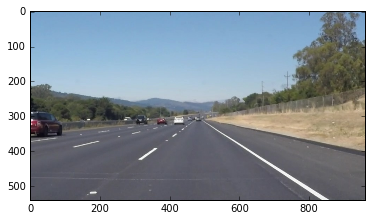

In [2]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')
#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)

**Note** that in the above image, the vertices of interest appear to be:
(100, 540), (480, 300), and (900, 540)

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [3]:
import math

def grayscale(img):
    """Applies the Grayscale transform"""
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_noise(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    Draws `lines` with `color` and `thickness`.
    
    Lines are drawn on the image inplace (mutates the image).
    """
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros(img.shape, dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

## Test on Images

Now you should build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [4]:
import os
os.listdir("test_images/")

['solidYellowCurve.jpg',
 'solidWhiteCurve.jpg',
 'solidWhiteRight.jpg',
 'whiteCarLaneSwitch.jpg',
 'solidYellowCurve2.jpg',
 'solidYellowLeft.jpg']

run your solution on all test_images and make copies into the test_images directory).

### Defining a Region of Interest
First, we'll want to ensure that we're defining our region of interest correctly.
The below code should help to mask off only the area of the image (and later, video) that we'll care about processing.

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


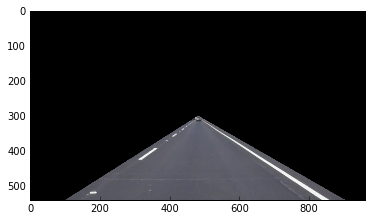

In [10]:
# Vertices from above
vertices = np.array([[(100, 540), (480, 300), (900, 540)]])
masked_image = region_of_interest(image, vertices)

#printing out some stats and plotting
print('The masked image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(masked_image)

### Applying the Canny Transform
Next, we'll want to ensure that we're filtering out everything we can except for the lane lines themselves.  
This isn't always possible, but the more we can successfully filter out noise, the easier it will be to draw the Hough lines.

The Canny-Transformed image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


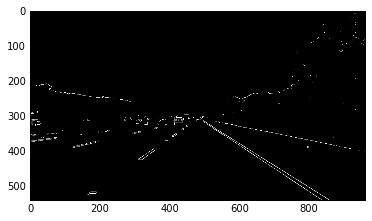

In [25]:
canny_image = canny(image, 255, 255)

#printing out some stats and plotting
print('The Canny-Transformed image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(canny_image, cmap='gray')

From repeated trials with different `low_threshold` and `high_threshold` values, it would appear that using `255, 255` filters out most of the noise while leaving the existing lane lines visible.

### Drawing the Hough Lines
First off, let's combine the results of the above two sections into a single image:

The masked, Canny-Transformed image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


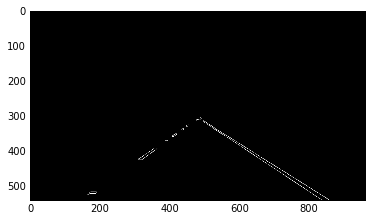

In [51]:
masked_canny_image = region_of_interest(canny_image, vertices)

#printing out some stats and plotting
print('The masked, Canny-Transformed image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(masked_canny_image, cmap='gray')

Now we're looking at just the lane lines, as identified by the Canny transformation. Cool!  
We'll use this image to draw the Hough lines.

The image with Hough Lines drawn is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


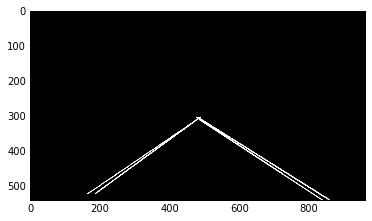

In [64]:
hough_image = hough_lines(masked_canny_image, rho = 1, theta = np.pi / 180, threshold = 50,
                          min_line_len = 200, max_line_gap = 200)
# See, e.g., http://docs.opencv.org/2.4/doc/tutorials/imgproc/imgtrans/hough_lines/hough_lines.html,
# especially 4. Probabilistic Hough Line Transform

#printing out some stats and plotting
print('The image with Hough Lines drawn is:', type(image), 'with dimensions:', image.shape)
plt.imshow(hough_image, cmap='gray')

Next, we'll superimpose these Hough Lines on our original image, so that the humans know that the car knows where the lane lines are.

The original image with Hough Lines superimposed is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


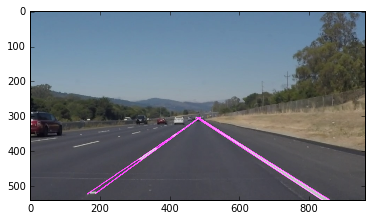

In [68]:
# Transform the hough_image into the same channel space.
# Or else, cv2.addWeighted will fail.
hough_image_BGR = cv2.cvtColor(hough_image, cv2.COLOR_GRAY2BGR)

b,g,r = cv2.split(hough_image_BGR)
g = 0 * g
b * 0.5 * b
hough_image_pink = cv2.merge((b, g, r))
# See, e.g., http://docs.opencv.org/3.0-beta/doc/py_tutorials/py_core/py_basic_ops/py_basic_ops.html

superimposed_image = weighted_img(hough_image_pink, image, α=0.8, β=1., λ=0.1)

#printing out some stats and plotting
print('The original image with Hough Lines superimposed is:', type(image), 'with dimensions:', image.shape)
plt.imshow(superimposed_image, cmap='gray')

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

In [65]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

ImportError: No module named 'moviepy'

In [ ]:
def process_image(image):
    # TODO: put your pipeline here,
    # you should return the final output (image with lines are drawn on lanes)

    return result

Let's try the one with the solid white lane on the right first ...

In [ ]:
white_output = 'white.mp4'
clip1 = VideoFileClip("solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image)
%time white_clip.write_videofile(white_output, audio=False)

Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

**At this point, if you were successful you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P0_example1.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform.  Modify your draw_lines function accordingly and try re-running your pipeline.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [ ]:
yellow_output = 'yellow.mp4'
clip2 = VideoFileClip('solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Reflections

Congratulations on finding the lane lines!  As the final step in this project, we would like you to share your thoughts on your lane finding pipeline... specifically, how could you imagine making your algorithm better / more robust?  Where will your current algorithm be likely to fail?

Please add your thoughts below,  and if you're up for making your pipeline more robust, be sure to scroll down and check out the optional challenge video below!


## Submission

If you're satisfied with your video outputs it's time to submit!


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [ ]:
challenge_output = 'extra.mp4'
clip2 = VideoFileClip('challenge.mp4')
challenge_clip = clip2.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))